In [1]:
#import packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import linalg as la
from functions import calculate_rsi
from functions import conduct_pca
from functions import walk_forward_pca
from functions import backtest2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
#import data, clean, dropnas
#Read data set and fill/drop na values 
data_raw = pd.read_csv('example_ms.csv')
data_ff = data_raw.fillna(method = 'ffill')
data_bf = data_ff.fillna(method = 'bfill')
data = data_bf.dropna()

#Convert date column to datetime and index by date
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

C:\Users\erica\AppData\Local\Temp\ipykernel_57396\2624893582.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ff = data_raw.fillna(method = 'ffill')
C:\Users\erica\AppData\Local\Temp\ipykernel_57396\2624893582.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_bf = data_ff.fillna(method = 'bfill')


,ticker,open,high,low,close,volume,open_interest,ema_close_8,ema_close_16,ema_close_32,...,rolling_hurst_exp_252,rolling_hurst_exp_504,adaptive_kernel_trend,kernel_momentum_div,kernel_slope,ema_spread_16_64,cmse_100,spectral_entropy,wavelet_mom,close_volatility_20
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,BP00-USA,1.6118,1.6235,1.6052,1.6085,107463,81371,1.607138,1.615475,1.597597,...,0.651458,0.638245,0.0,0,0.0465,-0.043083,6.30469,0.250255,0.005422,0.005073
2010-01-05,BP00-USA,1.6086,1.6148,1.5958,1.5992,102364,88847,1.607138,1.615475,1.597597,...,0.651458,0.638245,0.0,0,0.0465,-0.043083,6.30469,0.250255,0.005422,0.005073
2010-01-06,BP00-USA,1.5983,1.6059,1.5930,1.5992,106163,92191,1.607138,1.615475,1.597597,...,0.651458,0.638245,0.0,0,0.0465,-0.043083,6.30469,0.250255,0.005422,0.005073
2010-01-07,BP00-USA,1.5998,1.6052,1.5890,1.5935,90873,93464,1.607138,1.615475,1.597597,...,0.651458,0.638245,0.0,0,0.0465,-0.043083,6.30469,0.250255,0.005422,0.005073
2010-01-08,BP00-USA,1.5924,1.6105,1.5908,1.6027,122147,89496,1.607138,1.615475,1.597597,...,0.651458,0.638245,0.0,0,0.0465,-0.043083,6.30469,0.250255,0.005422,0.005073


In [3]:
#set list of lookback periods from 2 to 20 days, initialize rsis df indexed by original df
rsi_periods = list(range(2,21))
rsis = pd.DataFrame(index = data.index)

#loop through the list of periods and calculate the rsi for each date for each period by calling calculate_rsi() and store in rsis
for period in rsi_periods: 
    rsis[f'RSI{period}'] = calculate_rsi(data['close'], period)

rsis.head()

,RSI2,RSI3,RSI4,RSI5,RSI6,RSI7,RSI8,RSI9,RSI10,RSI11,RSI12,RSI13,RSI14,RSI15,RSI16,RSI17,RSI18,RSI19,RSI20
date,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-08,61.744966,61.744966,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529,38.016529


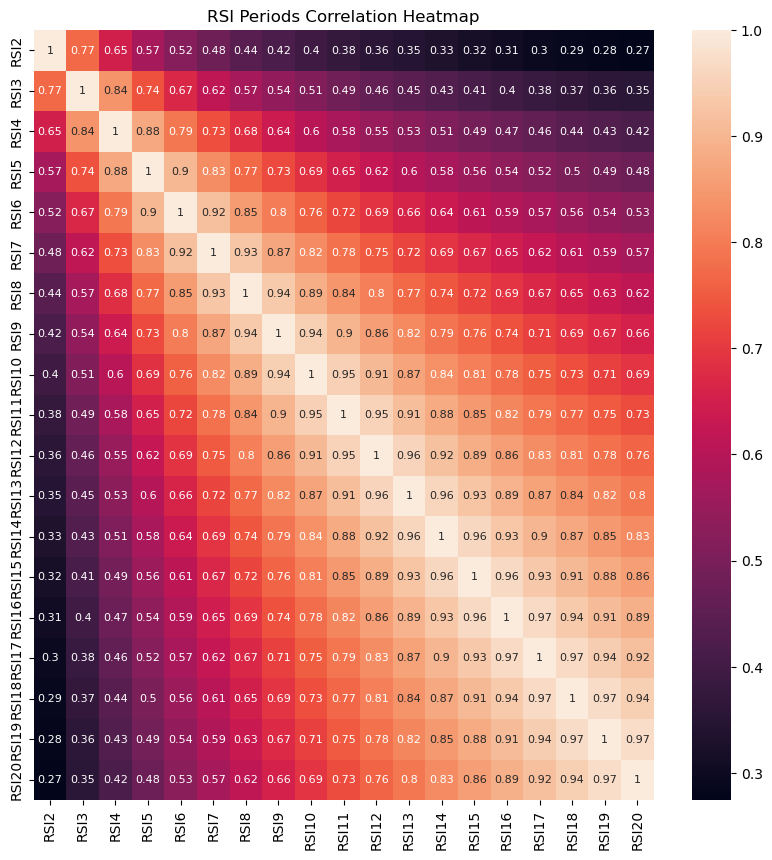

In [4]:
#plot correlation heatmap
correlation_matrix = rsis.corr()
plt.figure(figsize = (10,10))
sns.heatmap(correlation_matrix, annot = True, annot_kws={"size": 8})
plt.title('RSI Periods Correlation Heatmap')
plt.show()

In [5]:
#calculate pca output
pca_df, exp_var_ratio, pca = conduct_pca(rsis, num_components = 4)
print(pca_df.head())

                  PC1       PC2       PC3       PC4
date                                               
2010-01-05 -11.299426  1.646120 -0.896544  0.316803
2010-01-06 -11.299426  1.646120 -0.896544  0.316803
2010-01-07 -11.299426  1.646120 -0.896544  0.316803
2010-01-08  -2.619279  0.873362  0.318883  0.458417
2010-01-11   0.594756  0.904330  0.966789  0.529421


In [6]:
#explained variance ratio for specified num_components
exp_var_ratio

array([0.72143736, 0.13254703, 0.05142574, 0.0268567 ])

In [7]:
#find the sum of the explained variance ratio of the first two PCs and then find the relaltive explained variance ratios to assign 
#weights (w1 and w2) to PC1 and PC2. 
sum_exp_var = exp_var_ratio[0] + exp_var_ratio[1] + exp_var_ratio[2]
w1 = exp_var_ratio[0] / sum_exp_var
w2 = exp_var_ratio[1] / sum_exp_var
w3 = exp_var_ratio[2] / sum_exp_var

pca_df['combined'] = (w1*pca_df['PC1']) + (w2*pca_df['PC2']) + (w2*pca_df['PC3'])
pca_df

,PC1,PC2,PC3,PC4,combined
date,,,,,
2010-01-05,-11.299426,1.646120,-0.896544,0.316803,-8.893731
2010-01-06,-11.299426,1.646120,-0.896544,0.316803,-8.893731
2010-01-07,-11.299426,1.646120,-0.896544,0.316803,-8.893731
2010-01-08,-2.619279,0.873362,0.318883,0.458417,-1.912523
2010-01-11,0.594756,0.904330,0.966789,0.529421,0.747828
...,...,...,...,...,...
2025-02-11,3.460752,-1.260142,1.034786,-0.526784,2.724562
2025-02-12,3.697364,-0.810796,1.022952,-0.443611,2.977145
2025-02-13,2.830377,-1.080843,0.491784,-0.537061,2.169030


In [8]:
results_df = walk_forward_pca(data, rsis, pca_df, window_size=175, test_size=77, step_size=21)

# value_count = 0
# for i in range(len(results_df)):
#     if results_df['score'][i] >= 0.5 :
#         value_count +=1

# prop_value = value_count / (len(results_df['score']))
# prop_value

results_df

,start,end,score
0,2010-01-04,2010-12-30,0.246753
1,2010-02-03,2011-01-31,0.259740
2,2010-03-05,2011-03-02,0.259740
3,2010-04-05,2011-03-31,0.233766
4,2010-05-04,2011-05-02,0.220779
...,...,...,...
4264,2023-10-26,2024-10-15,0.168831
4265,2023-11-24,2024-11-13,0.194805
4266,2023-12-25,2024-12-12,0.194805
4267,2024-01-24,2025-01-16,0.207792


In [9]:
#implement backtest for where score is greater than 0.5 buy and sell when score < 0.5. 
capital = 100000

In [10]:
portfolio_value_list, trades = backtest2(data, results_df)

Total Return: -0.01%
Max Drawdown: -0.02%
Win Rate: 0.00%
Sharpe Ratio: -0.13


In [11]:
# Ensure the 'end_date' is in the index of data
if end_date in data.index:
    buy_price = data.loc[end_date, 'close']
else:
    print(f"Warning: {end_date} not found in data index.")
continue  # Skip this iteration if end_date is not found


NameError: name 'end_date' is not defined

In [ ]:
# Check for duplicates in the index of `data`
duplicates = data.index.duplicated()

if duplicates.any():
    print(f"Warning: Duplicate indices found at positions: {data.index[duplicates].tolist()}")
else:
    print("No duplicates found in the index.")
